In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
# from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
from sam.sam import SAM

from mega_sam_feri import MegaSAM
from NN_utils import train_multi_model
import pickle
import blosc


In [2]:
with open("compressed_training", "rb") as f:
    compressed_pickle = f.read()

depressed_pickle = blosc.decompress(compressed_pickle)
training_set = pickle.loads(depressed_pickle)  # turn bytes object back into data

with open("compressed_test", "rb") as f:
    compressed_pickle = f.read()

depressed_pickle = blosc.decompress(compressed_pickle)
test_set = pickle.loads(depressed_pickle)

# with open ('compressed_training', 'rb') as fp:
#     training_set = pickle.load(fp)
# with open ('compressed_test', 'rb') as fp:
#     test_set = pickle.load(fp)

In [3]:
# We can compress data like this
# import blosc
# pickled_data = pickle.dumps(test_set)  # returns data as a bytes object
# compressed_pickle = blosc.compress(pickled_data)

# with open("compressed_test", "wb") as f:
#     f.write(compressed_pickle)

5


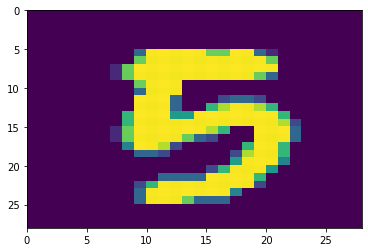

In [4]:
n = 244
print(training_set[n][1])
plt.pcolor(training_set[n][0].numpy().reshape((28,28)))
plt.gca().invert_yaxis()

# print(torch.argmax(model(training_set[0][0])))

In [5]:
output1 = 64
output2 = 32

MLP = nn.Sequential(
    nn.Linear(28 * 28, output1),
    nn.ReLU(),
    nn.Linear(output1, 10),
    # nn.ReLU(),
    # nn.Linear(output2, 10)
    )

In [6]:
model, training_losses, training_accuracies, validation_accuracies, optimizer = train_multi_model(train_data=training_set, test_data=test_set, model=MLP,
                        optim="MegaSAM", batch_size=128, epochs=5, tracking=True, alpha=.2, lr_M=10, lr=.2)
                        

Starting M: [tensor([[1.3706, 1.1836, 1.4389,  ..., 1.2711, 1.1349, 1.0224],
        [1.2410, 0.9836, 1.0918,  ..., 0.9815, 0.8754, 0.9994],
        [1.0472, 0.9313, 1.3028,  ..., 1.2116, 0.9969, 0.8366],
        ...,
        [0.7911, 1.1267, 1.2969,  ..., 1.2937, 1.1466, 0.7562],
        [1.2356, 0.8054, 1.0801,  ..., 1.3566, 0.7474, 0.9450],
        [1.3654, 1.4385, 0.7172,  ..., 1.1065, 1.1017, 0.7871]],
       grad_fn=<MulBackward0>), tensor([1.2487, 0.9965, 1.4136, 0.8018, 0.6199, 1.3061, 0.5036, 1.2602, 0.9233,
        0.7007, 0.9946, 1.0434, 1.4739, 1.1294, 0.9170, 0.9930, 0.4201, 0.7596,
        0.7808, 1.0932, 1.4355, 0.6670, 0.8176, 1.0246, 0.5537, 1.3455, 0.9569,
        1.4070, 1.1398, 0.8607, 1.2698, 0.8352, 0.9051, 1.8269, 1.1514, 0.8999,
        0.6586, 1.2158, 0.7529, 0.8599, 0.5684, 0.7033, 1.3177, 1.0564, 1.3572,
        1.1230, 1.3546, 1.0589, 0.9004, 1.0192, 1.1445, 0.9744, 0.9024, 0.7162,
        0.8729, 1.1418, 1.1688, 1.2229, 1.5397, 0.9041, 1.0399, 0.6676, 1.033

ValueError: can't optimize a non-leaf Tensor

In [ ]:
validation_accuracies

[0.9276000261306763,
 0.9429000020027161,
 0.955299973487854,
 0.9578999876976013,
 0.9663000106811523]

In [ ]:
print(optimizer.M_param_groups[0]['params'][0].size())
#print([tensor.size() for tensor in optimizer.M_param_groups[0]['params']])

torch.Size([64, 784])


In [ ]:
for i, chunk in enumerate(optimizer.M_param_groups[0]['params']):
    for j, row in enumerate(chunk):
        if not row.size():
                if abs(row) > 1.2:
                    print(f"{row} in chunk {i} position{j}")
        else:
            for k, element in enumerate(row):
                if abs(element) > 1.2:
                    print(f"{element} in chunk {i}, row {j} and position{k}")

120.3730697631836 in chunk 0, row 0 and position494
177.48426818847656 in chunk 0, row 3 and position631
653.5955200195312 in chunk 0, row 14 and position418
165.32151794433594 in chunk 0, row 17 and position570
9640.34765625 in chunk 0, row 19 and position97
157.94908142089844 in chunk 0, row 22 and position182
2527.271240234375 in chunk 0, row 23 and position248
767.9175415039062 in chunk 0, row 27 and position287
35.28828430175781 in chunk 0, row 29 and position181
23983.9375 in chunk 0, row 32 and position540
237.6343231201172 in chunk 0, row 33 and position238
2246.13232421875 in chunk 0, row 35 and position86
404.9916687011719 in chunk 0, row 35 and position277
182.11741638183594 in chunk 0, row 36 and position465
84.77960968017578 in chunk 0, row 39 and position278
1870.4244384765625 in chunk 0, row 42 and position555
700.7183837890625 in chunk 0, row 45 and position386
138.3374481201172 in chunk 0, row 45 and position699
122.71334075927734 in chunk 0, row 46 and position613
103

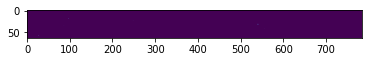

In [ ]:
#f, axarr = plt.subplots(1, 2)
plt.figure(figsize=(6, 10))
plt.imshow(optimizer.M_param_groups[0]['params'][0].detach())
#axarr[0].imshow(torch.diag(optimizer.M_param_groups[0]['params'][0]).detach().numpy())
#axarr[1].imshow(torch.diag(optimizer.M_param_groups[0]['params'][0]))
#plt.pcolor(optimizer.M_param_groups[0]['params'][0].detach()))
#plt.gca().invert_yaxis()

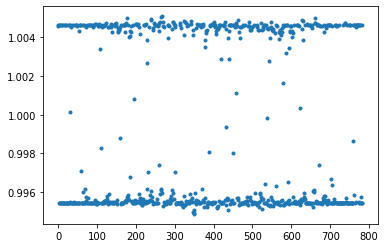

In [ ]:
plt.plot(optimizer.M_param_groups[0]['params'][0][21].detach(), '.')

In [ ]:
# print(list(model[0].parameters()))

In [ ]:
print(f"MegaSAM training accuracies: {training_accuracies}")
print(f"MegaSAM validation accuracies: {validation_accuracies}")

MegaSAM training accuracies: [0.8727499842643738, 0.9354000091552734, 0.9504500031471252, 0.9595833420753479, 0.9664166569709778]
MegaSAM validation accuracies: [0.9276000261306763, 0.9429000020027161, 0.955299973487854, 0.9578999876976013, 0.9663000106811523]


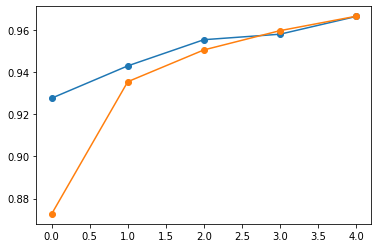

In [ ]:
plt.plot(validation_accuracies, 'o-')
plt.plot(training_accuracies, 'o-')

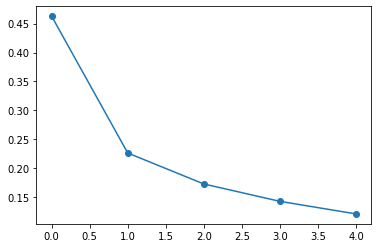

In [ ]:
plt.plot(training_losses, 'o-')